# Feature Engineering con *tsfresh* (HAR)

En este notebook se construirá un conjunto de *features* estadísticas masivas usando la librería **tsfresh** sobre el dataset HAR (ventanas de 2.56 s, 128 pasos, 9 canales).  

**Salidas principales:**  
- **Resumen de Características** (`../reports/tables/tsfresh_feature_summary.csv`): Archivo de metadatos que documenta la configuración usada, número de características iniciales, número tras la selección, y tiempos de cómputo.  
- **Set de Features Seleccionados** (`../artifacts/tsfresh_features_selected.npz`): Archivo comprimido que contiene la matriz final de *features* seleccionadas, junto con las etiquetas y metadatos.  
- **Figuras exploratorias** (`../reports/figures/`): Visualizaciones preliminares (PCA/UMAP) para evaluar la separabilidad de actividades en el espacio de *features*.  

## 1. Carga de datos y formato

* Reutilizar `har_processed.npz` (`X_train`, `y_train`, `channel_names`).
* Convertir cada muestra (ventana de 128 pasos, 9 canales) a un **DataFrame “long-form”** con columnas:

  * `id` = índice de muestra.
  * `time` = paso temporal (0–127).
  * `value` = valor de señal.
  * `kind` = canal (e.g., body_acc_x).
* Esto es el formato que *tsfresh* espera (`id`, `time`, `value`, `kind`).

In [10]:
# ============================================
# Paso 2 — Carga y formateo de datos (HAR → long-form tsfresh)
# ============================================

import os, gc
import numpy as np
import pandas as pd

# Configuración rápida
DATA_PATH = "../data/har_processed.npz"
CAP = 7000                 # pon un entero para trabajar sólo con las primeras N muestras
SAVE_LONG_PARQUET = False  # True si quieres cachear el long-form a disco (parquet)
PARQUET_PATH = "../artifacts/har_longform.parquet"

# 1) Cargar datos
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró: {DATA_PATH}")

data = np.load(DATA_PATH, allow_pickle=True)
X_train = data["X_train"]          # (n, 128, 9)
y_train = data["y_train"]          # (n,)
channel_names = data.get("channel_names", None)

n, T, C = X_train.shape
print(f"[Carga] X_train: {X_train.shape} | y_train: {y_train.shape}")

# Asegurar nombres de canales
if channel_names is None or len(channel_names) != C:
    channel_names = np.array([f"ch{i}" for i in range(C)], dtype=object)
else:
    channel_names = channel_names.astype(str)

# CAP opcional (para pruebas rápidas)
if CAP is not None and CAP < n:
    X_train = X_train[:CAP]
    y_train = y_train[:CAP]
    n = X_train.shape[0]
    print(f"[CAP] Usando sólo {n} muestras.")

# 2) Construir long-form (id, time, kind, value)
def to_long_form(X, channel_names):
    """
    X: np.ndarray (n, T, C)
    channel_names: array-like de longitud C
    Devuelve: DataFrame con columnas ['id','time','kind','value']
    """
    n, T, C = X.shape
    dfs = []
    ids = np.repeat(np.arange(n, dtype=np.int32), T)       # (n*T,)
    times = np.tile(np.arange(T, dtype=np.int16), n)        # (n*T,)
    for c in range(C):
        vals = X[:, :, c].reshape(n * T)                    # (n*T,)
        df_c = pd.DataFrame({
            "id": ids,
            "time": times,
            "kind": pd.Categorical([channel_names[c]] * (n * T)),
            "value": vals.astype(np.float32, copy=False)
        })
        dfs.append(df_c)
        del vals, df_c
        if (c + 1) % 3 == 0:
            gc.collect()
    df_long = pd.concat(dfs, ignore_index=True)
    # Tipos compactos
    df_long["id"] = df_long["id"].astype("int32")
    df_long["time"] = df_long["time"].astype("int16")
    # 'kind' ya es categoría; 'value' es float32
    return df_long

df_long = to_long_form(X_train, channel_names)
print(f"[Long-form] df_long shape: {df_long.shape}  (~ n*T*C filas)")


# 3) Target alineado
target = pd.Series(y_train.astype(int, copy=False), name="target")
target.index.name = "id"
assert len(target) == n, "target y X no tienen el mismo número de muestras"

# 4) Sanity checks mínimos
assert {"id", "time", "kind", "value"}.issubset(df_long.columns), "Faltan columnas en long-form"
assert df_long["id"].min() == 0 and df_long["id"].max() == n - 1, "IDs fuera de rango"
assert df_long["time"].min() == 0 and df_long["time"].max() == T - 1, "Times fuera de rango"
assert df_long["kind"].nunique() == C, "Nº de canales (kind) no coincide con C"
assert np.isfinite(df_long["value"]).all(), "Hay NaN/Inf en 'value'"

print(f"[Checks] kinds={df_long['kind'].unique().tolist()[:5]}... (total {df_long['kind'].nunique()})")
print(f"[Target] shape={target.shape}, clases={sorted(map(int, pd.unique(target)))}")

# 5) Cachear long-form a parquet
if SAVE_LONG_PARQUET:
    os.makedirs(os.path.dirname(PARQUET_PATH), exist_ok=True)
    df_long.to_parquet(PARQUET_PATH, index=False)
    print(f"[Cache] Guardado long-form en: {PARQUET_PATH}")

gc.collect()


[Carga] X_train: (7352, 128, 9) | y_train: (7352,)
[CAP] Usando sólo 7000 muestras.
[Long-form] df_long shape: (8064000, 4)  (~ n*T*C filas)
[Checks] kinds=[np.str_('body_acc_x'), np.str_('body_acc_y'), np.str_('body_acc_z'), np.str_('body_gyro_x'), np.str_('body_gyro_y')]... (total 9)
[Target] shape=(7000,), clases=[1, 2, 3, 4, 5, 6]


0


## 2. Extracción de features con *tsfresh*

* Usar funciones de extracción de `tsfresh.feature_extraction.extract_features`.
* Parámetros:

  * `column_id="id"`, `column_sort="time"`, `column_kind="kind"`, `column_value="value"`.
  * Usar configuración eficiente: `EfficientFCParameters()` (para empezar sin explotar RAM).
* Generar un DataFrame de features por muestra.

In [11]:
# ============================================
# Paso 3 — Extracción de features con tsfresh
# ============================================
import time, gc
from tsfresh.feature_extraction import extract_features, MinimalFCParameters

# Configuración
TSFRESH_PARAMS = MinimalFCParameters()   # set reducido y eficiente
N_JOBS = 4                                 # paralelismo (ajusta según tu CPU)
DISABLE_PROGRESS = False                   # True si no quieres barra de progreso

# Extracción
t0 = time.time()
X_tsfresh = extract_features(
    df_long,
    column_id="id",
    column_sort="time",
    column_kind="kind",
    column_value="value",
    default_fc_parameters=TSFRESH_PARAMS,
    n_jobs=N_JOBS,
    disable_progressbar=DISABLE_PROGRESS
)
extract_time = round(time.time() - t0, 2)

print(f"[tsfresh] Extracción terminada en {extract_time} seg")
print(f"[tsfresh] Shape inicial: {X_tsfresh.shape}")

# Limpieza y sanity check
# Asegurar que index de X_tsfresh coincide con target (id = fila)
X_tsfresh = X_tsfresh.sort_index()
target = target.sort_index()

assert all(X_tsfresh.index == target.index), "Desalineación entre features y target"

# Remover columnas con NaN/Inf si existen (pueden aparecer en features raros)
na_cols = X_tsfresh.columns[X_tsfresh.isna().any()].tolist()
if na_cols:
    print(f"[Warning] {len(na_cols)} columnas con NaN -> se eliminan")
    X_tsfresh = X_tsfresh.drop(columns=na_cols)

inf_cols = [c for c in X_tsfresh.columns if np.isinf(X_tsfresh[c]).any()]
if inf_cols:
    print(f"[Warning] {len(inf_cols)} columnas con Inf -> se eliminan")
    X_tsfresh = X_tsfresh.drop(columns=inf_cols)

# Reporte final
print(f"[tsfresh] Shape tras limpieza: {X_tsfresh.shape}")


Feature Extraction: 100%|██████████| 20/20 [00:45<00:00,  2.25s/it]


[tsfresh] Extracción terminada en 55.17 seg
[tsfresh] Shape inicial: (7000, 90)
[tsfresh] Shape tras limpieza: (7000, 90)



## 3. Selección de features

* Usar `tsfresh.select_features` con `y_train` para filtrar solo features relevantes.
* Argumentos:

  * `target=y_train`.
  * `fdr_level` (ej. 0.05).
* Esto reducirá miles de features a un subconjunto estadísticamente significativo.

In [9]:
# ============================================
# Paso 3 — Selección de features con tsfresh
# ============================================
import time
import numpy as np
import pandas as pd
from tsfresh.feature_selection import select_features

# Configuración
FDR_LEVEL = 0.05     # nivel de FDR (Benjamini–Yekutieli)
VERBOSE = True

# Asegurar alineación (por si vienes de CAP o reindexaciones)
X_tsfresh = X_tsfresh.sort_index()
target = target.sort_index()
assert len(X_tsfresh) == len(target), "Desalineación X_tsfresh vs target"
assert all(X_tsfresh.index == target.index), "Indices de X_tsfresh y target no coinciden"

# Sanity previo
if VERBOSE:
    n_raw = X_tsfresh.shape[1]
    print(f"[Selección] Features iniciales: {n_raw}")
    # Por si queda alguna rareza:
    na_cols = X_tsfresh.columns[X_tsfresh.isna().any()].tolist()
    if na_cols:
        print(f"[Selección][Warn] {len(na_cols)} col(s) con NaN -> se eliminan antes de seleccionar")
        X_tsfresh = X_tsfresh.drop(columns=na_cols)
    inf_cols = [c for c in X_tsfresh.columns if np.isinf(X_tsfresh[c]).any()]
    if inf_cols:
        print(f"[Selección][Warn] {len(inf_cols)} col(s) con Inf -> se eliminan antes de seleccionar")
        X_tsfresh = X_tsfresh.drop(columns=inf_cols)

# Selección de features
t0 = time.time()
X_sel = select_features(X_tsfresh, target, fdr_level=FDR_LEVEL)  # controla FDR por hipótesis múltiples
sel_time = round(time.time() - t0, 2)

# Reporte
n_selected = X_sel.shape[1]
print(f"[Selección] FDR={FDR_LEVEL} | seleccionadas: {n_selected} / {X_tsfresh.shape[1]}  "
      f"({100.0 * n_selected / max(1,X_tsfresh.shape[1]):.1f}%)")
print(f"[Selección] Tiempo: {sel_time} seg")
print(f"[Selección] Shape final: {X_sel.shape}")

# Checks finales
assert np.isfinite(X_sel.values).all(), "X_sel contiene NaN/Inf tras la selección"
assert all(X_sel.index == target.index), "Desalineación después de la selección"

# listado de primeras columnas seleccionadas (muestra)
muestra_cols = X_sel.columns[:10].tolist()
print(f"[Selección] Ejemplo de columnas: {muestra_cols}")


[Selección] Features iniciales: 90
[Selección] FDR=0.05 | seleccionadas: 81 / 90  (90.0%)
[Selección] Tiempo: 1.91 seg
[Selección] Shape final: (7000, 81)
[Selección] Ejemplo de columnas: ['body_acc_x__standard_deviation', 'body_acc_x__variance', 'body_acc_x__root_mean_square', 'total_acc_x__minimum', 'total_acc_x__median', 'total_acc_z__absolute_maximum', 'total_acc_y__maximum', 'total_acc_y__absolute_maximum', 'total_acc_x__standard_deviation', 'total_acc_x__variance']



## 4. Validaciones rápidas

* **Sanity checks**:

  * Revisar número de features antes y después de la selección.
  * Confirmar ausencia de NaN/Inf.
* **Separabilidad preliminar**: PCA/UMAP sobre features seleccionados para ver agrupamiento por actividad.
* **Balance vs redundancia**: contar cuántos features se quedan por canal.

[Sanity] Features antes: 90 | después de selección: 81
[Sanity] NaN en X_sel: False | Inf en X_sel: False


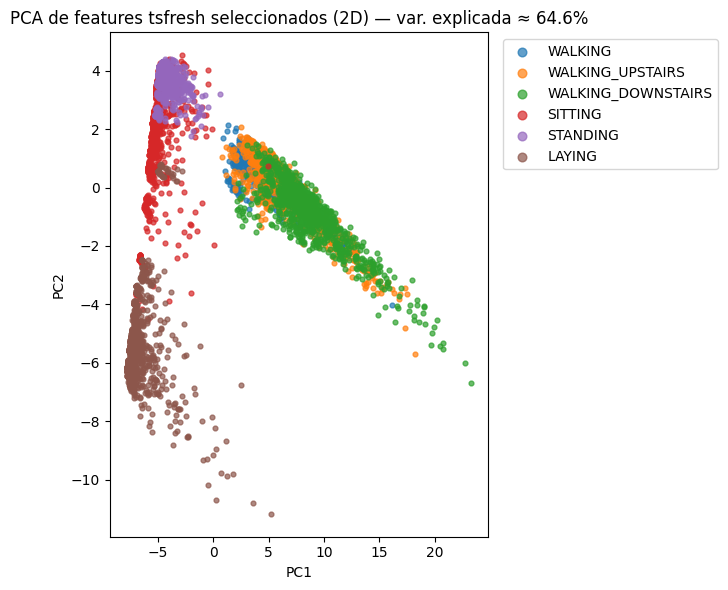

[Figura] Guardada: ../reports/figures/tsfresh_pca_selected_2d.png
[UMAP] No disponible o falló la proyección (se omite). Detalle: No module named 'umap'

[Balance] Features seleccionados por canal:
 kind
body_acc_x     9
total_acc_x    9
total_acc_z    9
total_acc_y    9
body_gyro_y    9
body_gyro_z    9
body_acc_z     9
body_acc_y     9
body_gyro_x    9
Name: count, dtype: int64


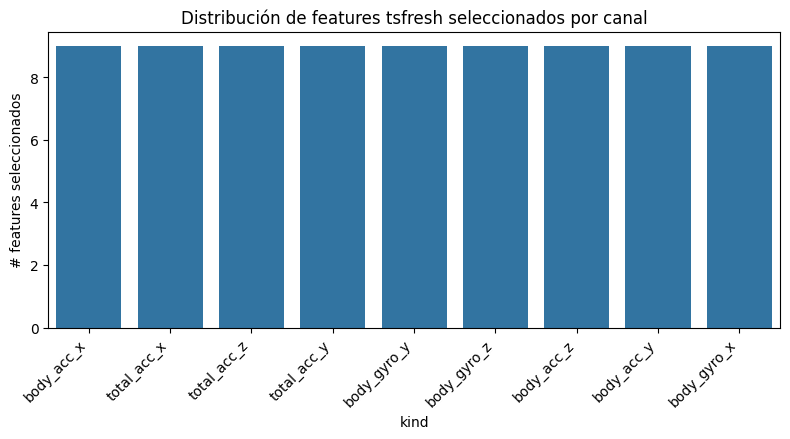

[Figura] Guardada: ../reports/figures/tsfresh_selected_per_kind.png

[Redundancia] Pares de features con |corr| > 0.95: 76 (primeros 10)
  - body_acc_x__standard_deviation  <->  body_acc_x__root_mean_square  (corr≈1.000)
  - body_acc_x__standard_deviation  <->  total_acc_x__standard_deviation  (corr≈0.998)
  - body_acc_x__standard_deviation  <->  body_acc_x__absolute_maximum  (corr≈0.984)
  - body_acc_x__standard_deviation  <->  body_acc_x__minimum  (corr≈0.967)
  - body_acc_x__standard_deviation  <->  body_acc_x__maximum  (corr≈0.981)
  - body_acc_x__variance  <->  total_acc_x__variance  (corr≈0.999)
  - body_acc_x__root_mean_square  <->  total_acc_x__standard_deviation  (corr≈0.997)
  - body_acc_x__root_mean_square  <->  body_acc_x__absolute_maximum  (corr≈0.984)
  - body_acc_x__root_mean_square  <->  body_acc_x__minimum  (corr≈0.967)
  - body_acc_x__root_mean_square  <->  body_acc_x__maximum  (corr≈0.980)


4795

In [12]:
# ============================================
# Paso 4 — Validaciones rápidas (tsfresh)
# ============================================
import os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

FIG_DIR = "../reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------
# 1) Sanity checks
# ------------------------
assert isinstance(X_tsfresh, pd.DataFrame), "X_tsfresh debe ser DataFrame"
assert isinstance(X_sel, pd.DataFrame), "X_sel debe ser DataFrame"
assert len(X_tsfresh) == len(X_sel) == len(target), "Desalineación de tamaños"

n_raw = X_tsfresh.shape[1]
n_sel = X_sel.shape[1]
print(f"[Sanity] Features antes: {n_raw} | después de selección: {n_sel}")

# NaN/Inf en seleccionadas
has_nan = X_sel.isna().any().any()
has_inf = np.isinf(X_sel.values).any()
print(f"[Sanity] NaN en X_sel: {has_nan} | Inf en X_sel: {has_inf}")
assert not has_nan and not has_inf, "X_sel contiene NaN o Inf"

# ------------------------
# 2) Separabilidad preliminar (PCA 2D)
# ------------------------
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X_sel.values)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_.sum()

# Mapeo de etiquetas a nombres
id_to_name = None
try:
    act_df = pd.read_csv("../data/activity_labels.txt", sep=r"\s+", header=None, names=["id","activity"])
    id_to_name = dict(zip(act_df.id.astype(int), act_df.activity.astype(str)))
except Exception:
    pass

def labels_to_names(y):
    if id_to_name is None:
        return pd.Series(y).map(lambda v: f"Class_{int(v)}")
    return pd.Series(y).map(lambda v: id_to_name.get(int(v), f"Class_{int(v)}"))

plt.figure(figsize=(7,6))
classes = np.unique(target.values)
for cls in classes:
    mask = (target.values == cls)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=12, alpha=0.7, label=labels_to_names([cls])[0])
plt.title(f"PCA de features tsfresh seleccionados (2D) — var. explicada ≈ {evr:.1%}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=1.8, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
pca_fig = os.path.join(FIG_DIR, "tsfresh_pca_selected_2d.png")
plt.savefig(pca_fig, dpi=160, bbox_inches="tight")
plt.show()
print("[Figura] Guardada:", pca_fig)

# (Opcional) Intento de UMAP si está instalado. Si no, se omite sin error.
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    Z_umap = reducer.fit_transform(X_scaled)
    plt.figure(figsize=(7,6))
    for cls in classes:
        mask = (target.values == cls)
        plt.scatter(Z_umap[mask, 0], Z_umap[mask, 1], s=12, alpha=0.7, label=labels_to_names([cls])[0])
    plt.title("UMAP de features tsfresh seleccionados (2D)")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.legend(markerscale=1.8, bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    umap_fig = os.path.join(FIG_DIR, "tsfresh_umap_selected_2d.png")
    plt.savefig(umap_fig, dpi=160, bbox_inches="tight")
    plt.show()
    print("[Figura] Guardada:", umap_fig)
except Exception as e:
    print("[UMAP] No disponible o falló la proyección (se omite). Detalle:", str(e))

# ------------------------
# 3) Balance vs redundancia
#    - Conteo de features por canal (kind)
#    - (Opcional) Resumen de correlaciones muy altas
# ------------------------

# Conteo por canal: los nombres de columnas tsfresh siguen patrón "kind__feature"
def infer_kind(col):
    # ejemplo: "body_acc_x__standard_deviation" -> "body_acc_x"
    if "__" in col:
        return col.split("__", 1)[0]
    return "unknown"

kind_counts = pd.Series([infer_kind(c) for c in X_sel.columns], name="kind").value_counts().sort_values(ascending=False)
print("\n[Balance] Features seleccionados por canal:\n", kind_counts)

# Barra de conteo por canal
plt.figure(figsize=(8,4.5))
sns.barplot(x=kind_counts.index, y=kind_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("# features seleccionados")
plt.title("Distribución de features tsfresh seleccionados por canal")
plt.tight_layout()
bar_fig = os.path.join(FIG_DIR, "tsfresh_selected_per_kind.png")
plt.savefig(bar_fig, dpi=160, bbox_inches="tight")
plt.show()
print("[Figura] Guardada:", bar_fig)

# (Opcional) Redundancia: top correlaciones absolutas muy altas entre features seleccionados
# Nota: con 81 columnas es manejable; si sube mucho, podría ser costoso.
corr_abs = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(corr_abs, 0.0)
high_pairs = np.argwhere(corr_abs > 0.95)  # umbral de alta redundancia
# filtrar duplicados i<j
high_pairs = [(i,j) for i,j in high_pairs if i < j]
if len(high_pairs) > 0:
    print(f"\n[Redundancia] Pares de features con |corr| > 0.95: {len(high_pairs)} (primeros 10)")
    for i,(a,b) in enumerate(high_pairs[:10]):
        print(f"  - {X_sel.columns[a]}  <->  {X_sel.columns[b]}  (corr≈{corr_abs[a,b]:.3f})")
else:
    print("\n[Redundancia] No se detectaron pares con |corr| > 0.95")

gc.collect()



## 5. Exportación para paper y trazabilidad

* Guardar:

  * CSV de resumen (`../reports/tables/tsfresh_feature_summary.csv`) con:

    * `n_features_raw`, `n_features_selected`, parámetros de extracción, tiempo de cómputo.
  * Artefactos:

    * `../artifacts/tsfresh_features_selected.npz` (X_tsfresh, y, meta).
  * (Opcional) Figura PCA/UMAP de features seleccionados.

[Export] Resumen guardado en: ../reports/tables/tsfresh_feature_summary.csv


,n_samples,n_features_raw,n_features_selected,fc_parameters,fdr_level,extraction_time_sec,selection_time_sec
0,7000,90,81,MinimalFCParameters,0.05,55.17,1.91


[Export] Artefacto guardado en: ../artifacts/tsfresh_features_selected.npz


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


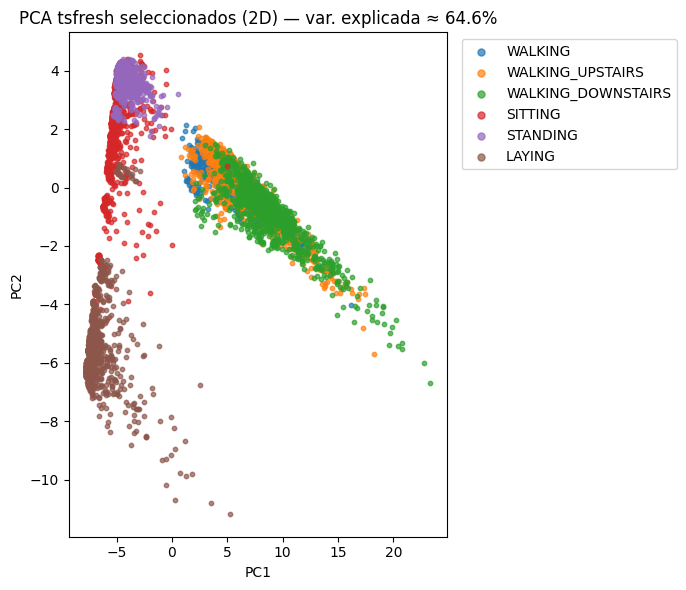

[Export] Figura PCA .eps guardada en: ../reports/figures/tsfresh_pca_selected_2d.eps


In [15]:
# ============================================
# Paso 5 — Exportación para paper y trazabilidad (tsfresh)
# ============================================
import os, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Carpetas de salida
ART_DIR = "../artifacts"
TAB_DIR = "../reports/tables"
FIG_DIR = "../reports/figures"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# --- Tiempos (si no existen de pasos previos, poner None)
extract_time = float(extract_time) if 'extract_time' in globals() else None
sel_time     = float(sel_time) if 'sel_time' in globals() else None

# --- Parámetros (nombre del set de funciones)
try:
    PARAMS_NAME = TSFRESH_PARAMS.__class__.__name__
except Exception:
    PARAMS_NAME = "UnknownFCParameters"

# --- Resumen y guardado CSV
summary_row = dict(
    n_samples=int(X_sel.shape[0]),
    n_features_raw=int(X_tsfresh.shape[1]),
    n_features_selected=int(X_sel.shape[1]),
    fc_parameters=PARAMS_NAME,
    fdr_level=float(FDR_LEVEL) if 'FDR_LEVEL' in globals() else None,
    extraction_time_sec=extract_time,
    selection_time_sec=sel_time
)
df_summary = pd.DataFrame([summary_row])
csv_path = os.path.join(TAB_DIR, "tsfresh_feature_summary.csv")
df_summary.to_csv(csv_path, index=False)
print("[Export] Resumen guardado en:", csv_path)
display(df_summary)

# --- Artefacto .npz (features seleccionados)
meta = dict(
    fc_parameters=PARAMS_NAME,
    fdr_level=float(FDR_LEVEL) if 'FDR_LEVEL' in globals() else None,
    extraction_time_sec=extract_time,
    selection_time_sec=sel_time,
    note="HAR tsfresh selected features; index aligned with target"
)
npz_path = os.path.join(ART_DIR, "tsfresh_features_selected.npz")
np.savez_compressed(
    npz_path,
    X=X_sel.values.astype(np.float32, copy=False),
    y=target.values.astype(np.int64, copy=False),
    columns=np.array(X_sel.columns, dtype=object),
    meta=meta
)
print("[Export] Artefacto guardado en:", npz_path)

# --- Figuras .eps (PCA y, si está disponible, UMAP)
# Recomputamos PCA para asegurar vectorial (.eps)
X_scaled = StandardScaler().fit_transform(X_sel.values)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_.sum()

# Mapeo de etiquetas a nombres (si existe archivo)
id_to_name = None
try:
    act_df = pd.read_csv("../data/activity_labels.txt", sep=r"\s+", header=None, names=["id","activity"])
    id_to_name = dict(zip(act_df.id.astype(int), act_df.activity.astype(str)))
except Exception:
    pass

def labels_to_names(y):
    if id_to_name is None:
        return pd.Series(y).map(lambda v: f"Class_{int(v)}")
    return pd.Series(y).map(lambda v: id_to_name.get(int(v), f"Class_{int(v)}"))

plt.figure(figsize=(7,6))
classes = np.unique(target.values)
for cls in classes:
    mask = (target.values == cls)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=10, alpha=0.7, label=labels_to_names([cls])[0])
plt.title(f"PCA tsfresh seleccionados (2D) — var. explicada ≈ {evr:.1%}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=1.6, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
pca_eps = os.path.join(FIG_DIR, "tsfresh_pca_selected_2d.eps")
plt.savefig(pca_eps, format="eps", bbox_inches="tight")
plt.show()
print("[Export] Figura PCA .eps guardada en:", pca_eps)



## 6. Limitaciones y plan de combinación

* Reconocer limitaciones:

  * *tsfresh* es intensivo en tiempo/memoria.
  * Riesgo de sobreajuste si no se controla selección.
* Plan experimental:

  * Comparar **solo PyTS** vs **solo tsfresh** vs **PyTS+tsfresh** en Notebook 04 (modelado).
